# Tarea #2: Los buenos ejemplos se copian

Para esta tarea trataremos de reproducir dos visualizaciones del The Economist. Para ellos nos enfocaremos en imitar la paleta de colores que ocuparon, las visualizaciones y las anotaciones que incluyen en los gráficos, además de todos los otros detalles de título, subtítulo, etcétera.

## Problema 1: Behavioural finance

## Problema 2: Happiness economics

In [31]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.patches as patches

from flexitext import flexitext
import matplotlib.font_manager as fm
from matplotlib import lines

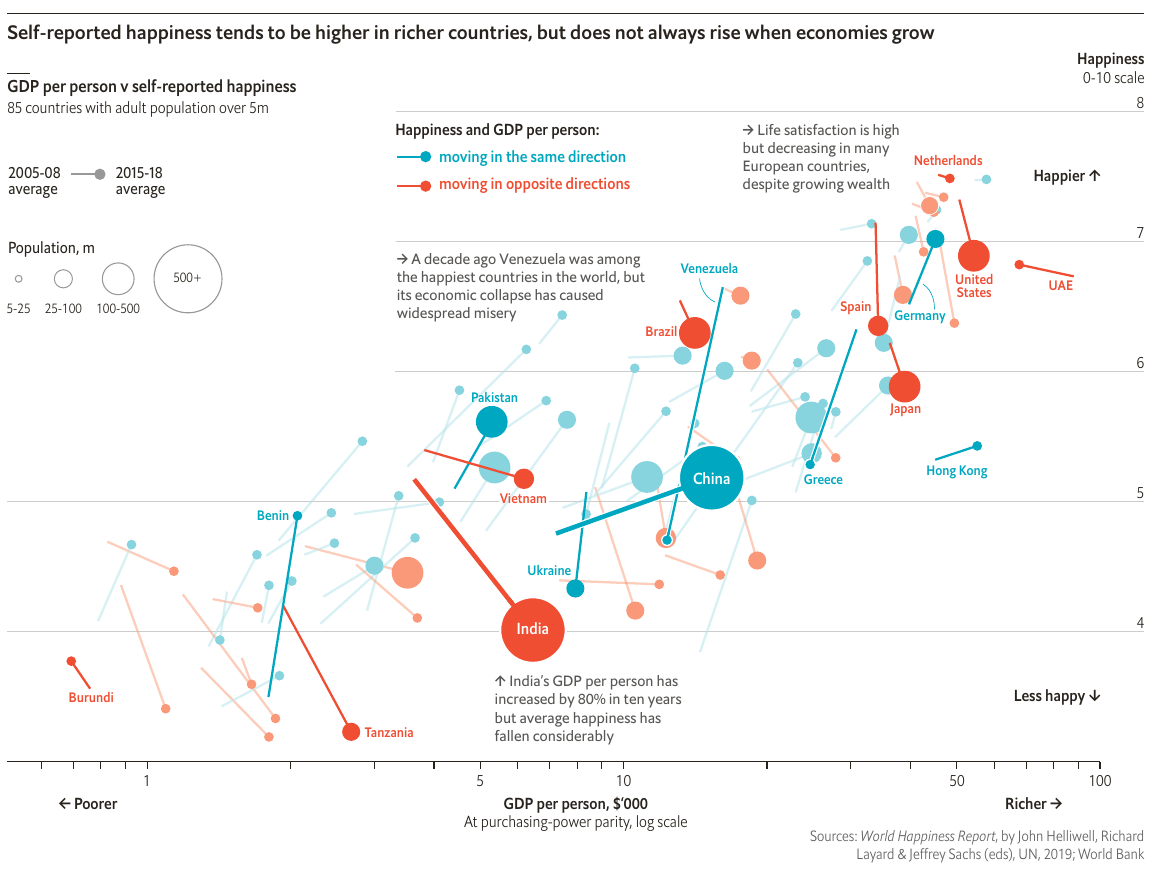

In [32]:
Image("./images/02-happiness-economics.png")

### Datos

El equipo del The Economist publicaron su código para la extracción y procesamiento de datos en [su GitHub](https://github.com/TheEconomist/graphic-detail-data/tree/master/data/2019-03-23_happiness-economics). De hecho, el código para hacer el gráfico también está incluido, pero -lamentablemente para ustedes- usan R en vez de Python. Los datos ya han sido bajados y compilados, los cuales se ubican en `data/02-happiness-economics.csv`

### Ayuda 1

Si se dan cuenta, hay datos para un total de 125 países en el archivo `csv`, pero en el gráfico solo hay 85. Si se fijan bien en [la metodologia publicada](https://github.com/TheEconomist/graphic-detail-data/blob/master/data/2019-03-23_happiness-economics/README.Rmd#L160), el The Economist selecciona los países con una población de más de 5 millones de personas en el año 2018 para graficarlos (de ahí que sean menos).

### Ayuda 2

El color de cada círculo está relacionado al valor de la columna `paradox`.

In [39]:
df = pd.read_csv('./data/02-happiness-economics.csv')
df = df[df.columns[1:]]
#Filtra paises que tengan + de 5M hab en el 2018
paises_5m = df[(df['year']==2018)&(df['pop']>5000000)]['name'].unique()
df = df[df['name'].isin(paises_5m)]
df['gdp.pc'] = df['gdp.pc']/1000
df_2 = df.copy()

pop_break_map = {'<25m': '5-25', '25m-100m': '25-100', '100m-500m': '100-500', '500m+': '500+'}
df['pop.break'] = df['pop.break'].map(pop_break_map)
# Hace pivot entre paises y year
df = df.pivot(index='name', columns='year', values=['happy', 'gdp.pc', 'paradox', 'pop.break', 'pop.levels', 'quadrant']).reset_index()
df.columns = [col[0] if col[1]=='' else col[0] + '_' + str(col[1])  for col in df.columns]
df['pop.levels_sq'] = df['pop.levels_2018'] ** 2
df['name'] = df['name'].apply(lambda x: "UAE" if x=='United Arab Emirates' else x)

In [40]:
df['pop.break_2018'].unique()

array(['5-25', '25-100', '100-500', '500+'], dtype=object)

In [41]:
# Para graficar:
# -------------
# name: nombre pais
# happy (2018): eje y de los circulos
# gdp.pc (2018): eje x de los circulos (log)
# Paradox: color
# pop.levels (2018): tamaño de circulo
# pop.breaks (2018): texto leyenda

df.head()

,name,happy_2008,happy_2018,gdp.pc_2008,gdp.pc_2018,paradox_2008,paradox_2018,pop.break_2008,pop.break_2018,pop.levels_2008,pop.levels_2018,quadrant_2008,quadrant_2018,pop.levels_sq
0,Afghanistan,3.72359,3.067623,1.298143,1.800812,True,True,5-25,5-25,1,1,rise-fall,rise-fall,1
1,Argentina,6.115706,6.013036,17.643281,18.486857,True,True,25-100,25-100,2,2,rise-fall,rise-fall,4
2,Australia,7.293279,7.215276,40.313264,44.934614,True,True,5-25,5-25,1,1,rise-fall,rise-fall,1
3,Austria,7.151583,7.283451,43.4699,45.602022,False,False,5-25,5-25,1,1,rise-rise,rise-rise,1
4,Azerbaijan,4.704407,5.198041,12.77313,15.943566,False,False,5-25,5-25,1,1,rise-rise,rise-rise,1


In [42]:
def scatter_line(df, ax, col_x_ini, col_x_end, col_y_ini, col_y_end, color, size_map, range_size, alpha_scatter, alpha_line, paleta):
    df_ = df.copy()
    for i_df in range(df_.shape[0]):
        ax.plot([df_[col_x_ini].iloc[i_df], df_[col_x_end].iloc[i_df]], 
                [df_[col_y_ini].iloc[i_df], df_[col_y_end].iloc[i_df]],
                color=paleta[df_[color].iloc[i_df]],
                alpha=alpha_line,
                linewidth=[3.0 if df_['pop.break_2018'].iloc[i_df]=='500+' else 1.5][0])
    
    df_['pop.levels_2018'] = df_['pop.levels_2018'].apply(lambda x: size_map[x])
    sns.scatterplot(data=df_, x=col_x_end, y=col_y_end, hue=color, size='pop.levels_2018', sizes=range_size, alpha=alpha_scatter,
                    legend=False, palette=paleta, edgecolor='white', linewidth=1, ax=ax)

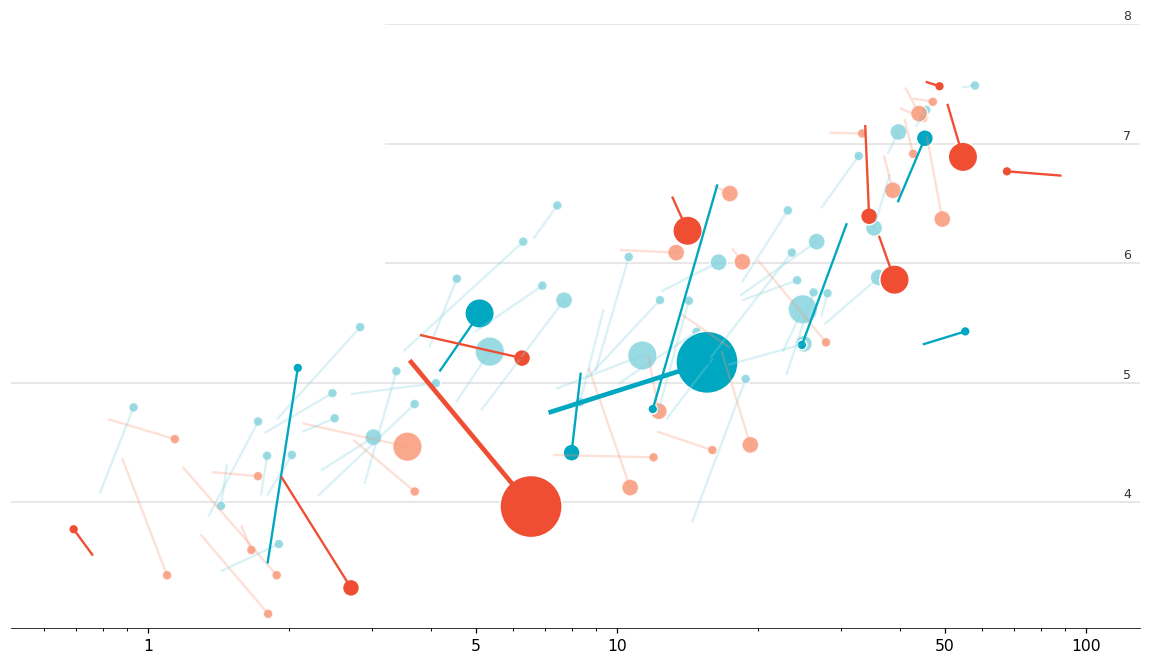

In [43]:
fig, ax = plt.subplots(1,1, figsize=(13, 7), dpi=112)

paleta = ['#00a7c0', '#f04e33']
paleta_2 = ['#87d4df', '#f9997a']

# scatterplot
paises = ['Burundi', 'Tanzania', 'Benin', 'Pakistan', 'Vietnam', 'India', 'Ukraine', 'Venezuela', 'Brazil',
          'China', 'Greece', 'Spain', 'Japan', 'Germany', 'Netherlands', 'United States', 'Hong Kong', 'UAE']
df_paises_1 = df[df['name'].isin(paises)]
df_paises_2 = df[~df['name'].isin(paises)]

size_map_ = {1:40, 2:120, 3:360, 4:1600}
scatter_line(df_paises_2, ax, 'gdp.pc_2008', 'gdp.pc_2018', 'happy_2008', 'happy_2018',
             'paradox_2018', size_map_, (40, 360), 0.85, 0.3, paleta_2)

scatter_line(df_paises_1, ax, 'gdp.pc_2008', 'gdp.pc_2018', 'happy_2008', 'happy_2018',
             'paradox_2018', size_map_, (40, 1600), 1, 1, paleta)

plt.xscale('log')

# Recuadro superior izquierdo
sq_1 = patches.Rectangle((0, 5.5), 3.2, 2.5, linewidth=1, edgecolor=None, facecolor='w')
ax.add_patch(sq_1)


# Modificacion grilla
ax.set_xticks([1, 5, 10, 50, 100])
ax.set_xticklabels([1, 5, 10, 50, 100])
ax.set_yticks([4, 5, 6, 7, 8])
ax.set_yticklabels([4, 5, 6, 7, 8])
ax.yaxis.set_tick_params(labelleft=False, length=0)
ax.grid(axis = "y", color="#333333", lw=0.15)
ax.set_axisbelow(True)

ax.set_ylim(2.95, 8)
ax.set_xlim(0.51, 130)

PAD_y = 0.01
PAD_x = 120
for label in [4, 5, 6, 7, 8]:
    ax.text(
        PAD_x, label + PAD_y, label, 
        #fontfamily="Comic Sans MS",
        ha="left", va="bottom", fontsize=8, fontweight=100, color="#333333"
    )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)

ax.set_xlabel('')
ax.set_ylabel('')

plt.show()

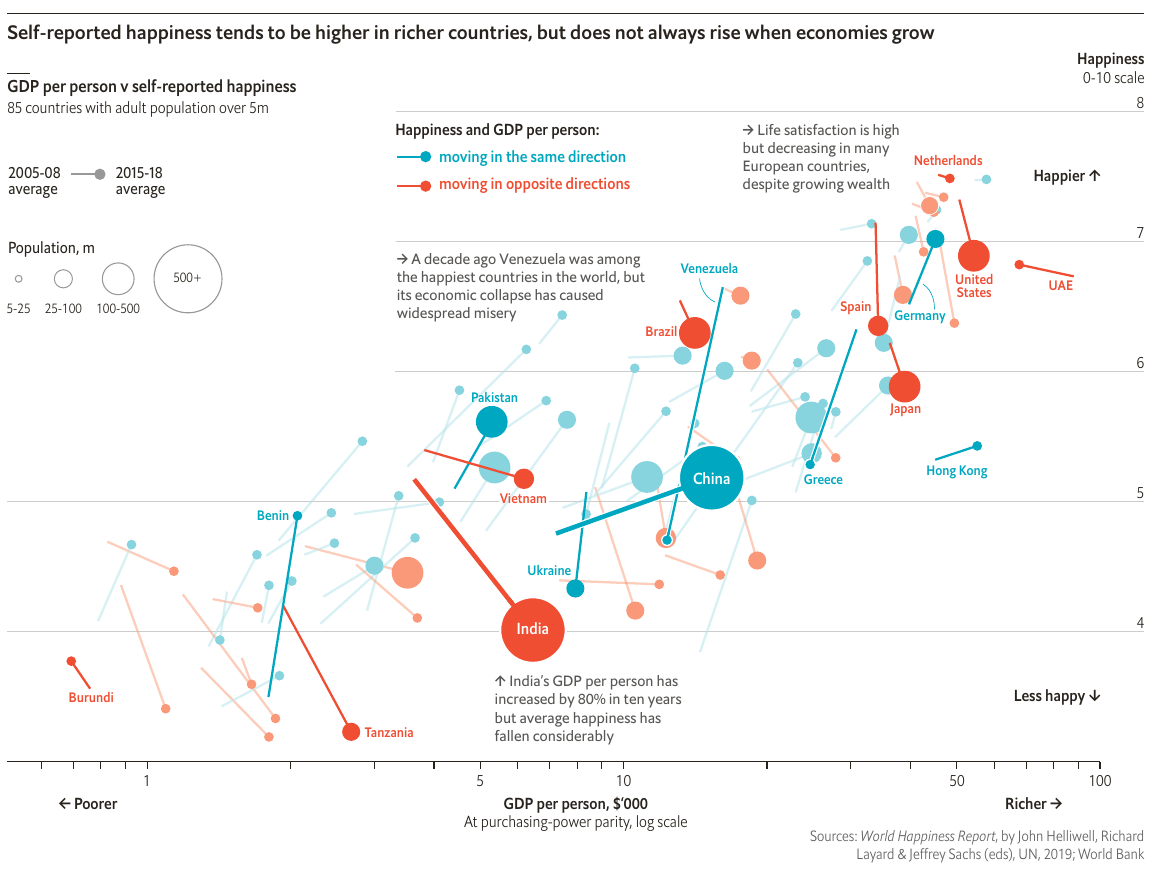

In [44]:
Image("./images/02-happiness-economics.png")